In [45]:
import pandas as pd
import nltk
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

#### Entendimiento y Análisis de Calidad

                                         Textos_espanol  sdg
2498  Sin embargo, ha sido la experiencia en muchos ...    5
3361  Está claro que queda mucho terreno por recorre...    5
1198  Los documentos analizados incluían documentos ...    4
1345  Un valor de cero indica que no hay diferencia ...    4
5     Probar pronto la medicina rural puede crear el...    3
2670  Implica que ella da una compensación a su espo...    5
353   La esperanza de vida entre los jóvenes de 20 a...    3
1342  Los gobiernos central y provinciales son respo...    4
1457  Entre ellas cabe citar: el escaso desarrollo d...    4
1856  Las evaluaciones externas pueden aplicarse a t...    4
Total de filas duplicadas: 0

Valores faltantes por columna:
Textos_espanol    0
sdg               0
dtype: int64

Total de valores faltantes en el dataset: 0


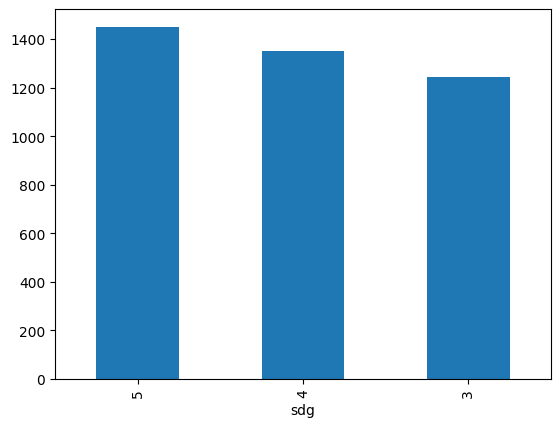

In [46]:
# Cargar los datos
df = pd.read_excel('data.xlsx')

# Mostrar una muestra de los datos
sample = df.sample(10)
print(sample)

#Explorar que las etiquetas sean congruentes con la información del negocio
df['sdg'].value_counts().plot(kind='bar')

# Verificar valores duplicados
duplicados = df.duplicated()
print(f"Total de filas duplicadas: {duplicados.sum()}")

# Mostrar las filas duplicadas (si las hay)
if duplicados.sum() > 0:
    print("Filas duplicadas:")
    print(df[duplicados])

# Verificar valores faltantes (NaN)
valores_faltantes = df.isnull().sum()
print("\nValores faltantes por columna:")
print(valores_faltantes)

# Verificar si hay alguna fila con valores faltantes
total_nan = df.isnull().sum().sum()
print(f"\nTotal de valores faltantes en el dataset: {total_nan}")

# Mostrar las filas que contienen valores faltantes (si las hay)
if total_nan > 0:
    print("\nFilas con valores faltantes:")
    print(df[df.isnull().any(axis=1)])


En la muestra de datos proporcionada, los comentarios están clasificados de acuerdo con tres categorías asociadas a los ODS 3, 4 y 5, lo que refleja un esfuerzo por relacionar las opiniones ciudadanas con estos objetivos. En cuanto a la completitud, los datos parecen estar completos, ya que no se observan valores faltantes en los comentarios ni en sus respectivas clasificaciones. En cuanto a la unicidad, es importante verificar si los comentarios están duplicados, lo cual podría afectar el análisis y la interpretación de los resultados; este aspecto no se encuentran valores duplicados en la base de  datos. En términos de consistencia, las etiquetas asociadas a los ODS parecen congruentes con el contenido de los comentarios, ya que los temas tratados se alinean con los objetivos correspondientes (por ejemplo, educación en el ODS 4 y equidad de género en el ODS 5). Por último, la validez de los datos parece adecuada, dado que las clasificaciones son coherentes con las categorías esperadas del negocio. Al observar la distribución de los datos en un histograma, se evidencia que la clasificación de los comentarios está bien balanceada entre las categorías, lo cual es positivo para los modelos de clasificación que se propongan.

In [47]:
# Definir características y etiquetas
X = df['Textos_espanol']
y = df['sdg']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

3239 810


### Preprocesamiento y Limpieza

En el preprocesamiento de los datos textuales se implementaron varias estrategias clave para mejorar la calidad y relevancia del texto antes de aplicar modelos de clasificación. En primer lugar, se utilizó la lematización, que consiste en reducir las palabras a su forma base o raíz (como convertir "corriendo" a "correr"). Esto permite una mayor coherencia en el análisis, ya que diferentes formas de una palabra se tratan como una sola, lo que reduce la variabilidad innecesaria. También se llevó a cabo la eliminación de stopwords, es decir, palabras muy comunes en el lenguaje (como "el", "de", "y") que no aportan información valiosa para la clasificación, lo cual simplifica el texto sin perder significado. Además, se eliminaron caracteres numéricos y signos de puntuación, ya que no contribuyen al análisis semántico de los comentarios y pueden generar ruido en el proceso de modelado. Estas estrategias aseguran que el texto preprocesado esté centrado en las palabras que realmente aportan información relevante, facilitando un análisis más efectivo y preciso en las siguientes etapas del proyecto.

In [48]:
nltk.download('stopwords')

# Cargar el modelo lemmatizador en español
nlp = spacy.load('es_core_news_sm')

# Obtener stopwords en español
spanish_stopwords = set(stopwords.words('spanish'))  # Convertir a set para mayor eficiencia en la búsqueda

# Definir un tokenizador que lematiza y elimina stopwords
def lemmatize_and_remove_stopwords(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc if token.is_alpha]  # Lemmatizar y eliminar tokens numéricos y de puntuación
    tokens_without_stopwords = [token for token in lemmatized_tokens if token not in spanish_stopwords]  # Eliminar stopwords
    return ' '.join(tokens_without_stopwords)  # Unir los tokens en un solo string


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sebastiangaona/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Entrenamiento de los modelos 

Se decidieron utilizar varios algoritmos de clasificación para analizar la relación entre los comentarios y los Objetivos de Desarrollo Sostenible (ODS) debido a que las características están balanceadas, lo que permite aplicar diversos enfoques sin preocuparse por el sesgo hacia una clase específica. Se eligieron los siguientes algoritmos:

Multinomial Naive Bayes (MNB): Este modelo es adecuado para datos categóricos y frecuencias de palabras, ya que asume que las características siguen una distribución multinomial. Es eficiente y fácil de interpretar, lo que lo hace ideal para el análisis de texto.

Complement Naive Bayes (CNB): Similar a MNB, este algoritmo está diseñado para corregir algunos problemas que MNB enfrenta en casos donde las clases están desbalanceadas. Aunque no es necesario en este caso, su uso asegura una mayor precisión en ciertas tareas de clasificación.

Support Vector Classifier (SVC): Este modelo busca un hiperplano óptimo que separa las clases, siendo útil en escenarios de clasificación binaria y multiclase. Es robusto y funciona bien con datos balanceados, como los presentes en este proyecto.

Random Forest (RF): Un algoritmo basado en árboles de decisión que combina múltiples árboles para mejorar la precisión. Es muy útil para capturar interacciones complejas entre variables y es menos propenso al sobreajuste.

Gradient Boosting (GB): Este algoritmo crea modelos de forma secuencial, corrigiendo los errores de los modelos anteriores. Es poderoso para capturar patrones complejos en los datos y se utiliza por su capacidad de generalización.

Logistic Regression (LR): Un modelo lineal clásico para clasificación binaria y multiclase, que es eficiente y fácil de interpretar. Se selecciona debido a su simplicidad y capacidad para manejar relaciones lineales entre las características.

Estos algoritmos se eligieron por su capacidad para manejar tanto datos lineales como no lineales, asegurando un rendimiento robusto en la clasificación balanceada de los comentarios.

In [49]:
# Definir los pipelines de cada algoritmo para clasificación de texto
pipeMNB = Pipeline([
    ('tfi', TfidfVectorizer(tokenizer=lemmatize_and_remove_stopwords, ngram_range=(1, 4))),
    ('clf', MultinomialNB()),
])

pipeCNB = Pipeline([
    ('tfi', TfidfVectorizer(tokenizer=lemmatize_and_remove_stopwords, ngram_range=(1, 4))),
    ('clf', ComplementNB()),
])

pipeSVC = Pipeline([
    ('tfi', TfidfVectorizer(tokenizer=lemmatize_and_remove_stopwords, ngram_range=(1, 4))),
    ('clf', LinearSVC()),
])

pipeRF = Pipeline([
    ('tfi', TfidfVectorizer(tokenizer=lemmatize_and_remove_stopwords, ngram_range=(1, 4))),
    ('clf', RandomForestClassifier(n_estimators=100)),  
])

pipeGB = Pipeline([
    ('tfi', TfidfVectorizer(tokenizer=lemmatize_and_remove_stopwords, ngram_range=(1, 4))),
    ('clf', GradientBoostingClassifier(n_estimators=100)),  
])

pipeLR = Pipeline([
    ('tfi', TfidfVectorizer(tokenizer=lemmatize_and_remove_stopwords, ngram_range=(1, 4))),
    ('clf', LogisticRegression(max_iter=1000)),  
])

In [50]:
# Entrenar los modelos con el conjunto de entrenamiento
pipeMNB.fit(X_train, y_train)
pipeCNB.fit(X_train, y_train)
pipeSVC.fit(X_train, y_train)
pipeRF.fit(X_train, y_train)
pipeGB.fit(X_train, y_train)
pipeLR.fit(X_train, y_train)

# Predecir y evaluar los modelos con el conjunto de prueba
predictMNB = pipeMNB.predict(X_test)
predictCNB = pipeCNB.predict(X_test)
predictSVC = pipeSVC.predict(X_test)
predictRF = pipeRF.predict(X_test)
predictGB = pipeGB.predict(X_test)
predictLR = pipeLR.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/

#### Evaluación

In [51]:
print("MNB")
print(classification_report(y_test, predictMNB))

print("CNB")
print(classification_report(y_test, predictCNB))

print("SVC")
print(classification_report(y_test, predictSVC))

print("RF")
print(classification_report(y_test, predictRF))

print("GB")
print(classification_report(y_test, predictGB))

print("LR")
print(classification_report(y_test, predictLR))

MNB
              precision    recall  f1-score   support

           3       1.00      0.78      0.88       250
           4       0.92      0.96      0.94       268
           5       0.85      0.97      0.91       292

    accuracy                           0.91       810
   macro avg       0.92      0.91      0.91       810
weighted avg       0.92      0.91      0.91       810

CNB
              precision    recall  f1-score   support

           3       0.99      0.93      0.96       250
           4       0.94      0.98      0.96       268
           5       0.95      0.97      0.96       292

    accuracy                           0.96       810
   macro avg       0.96      0.96      0.96       810
weighted avg       0.96      0.96      0.96       810

SVC
              precision    recall  f1-score   support

           3       0.99      0.98      0.99       250
           4       0.96      0.98      0.97       268
           5       0.98      0.97      0.98       292

    accu

MNB Confusion Matrix


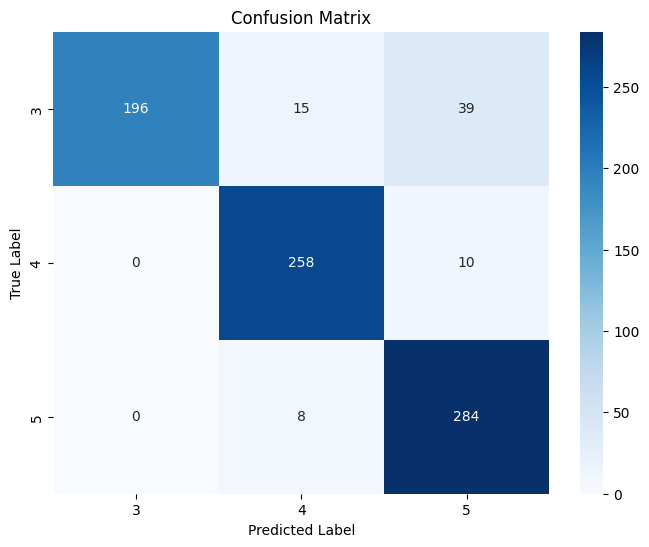

CNB Confusion Matrix


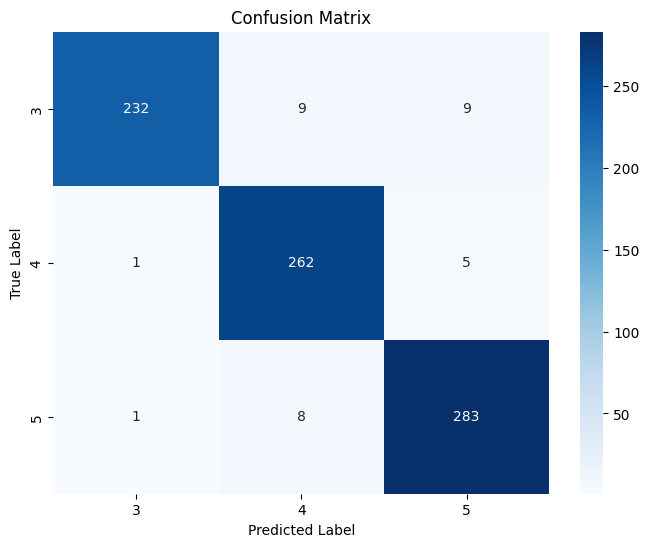

SVC Confusion Matrix


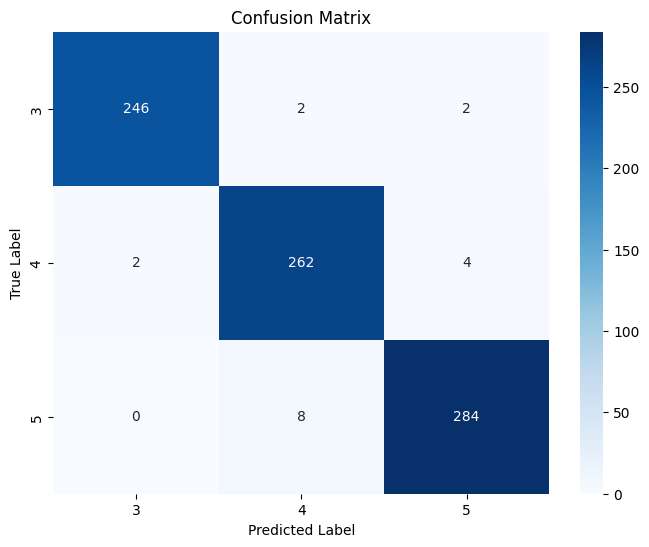

RF Confusion Matrix


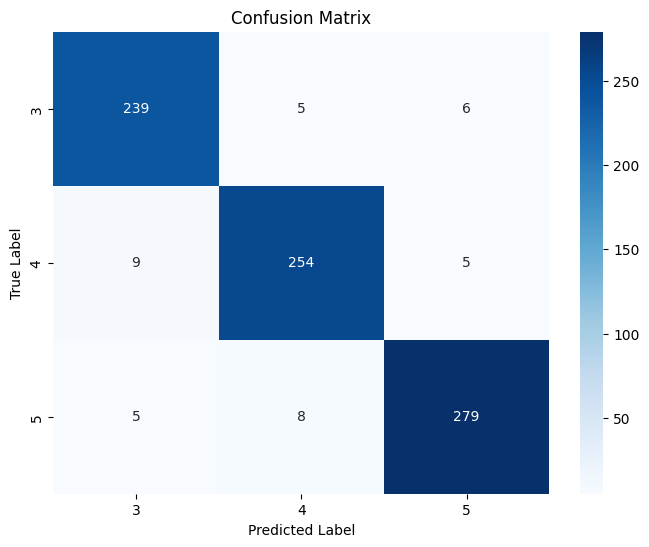

GB Confusion Matrix


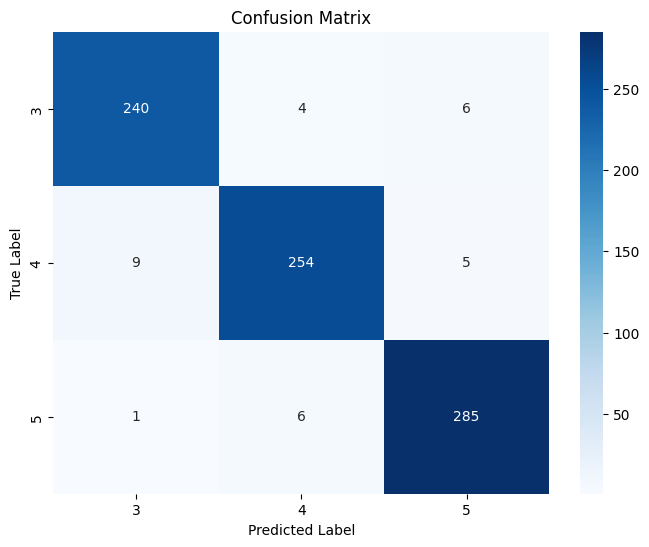

LR Confusion Matrix


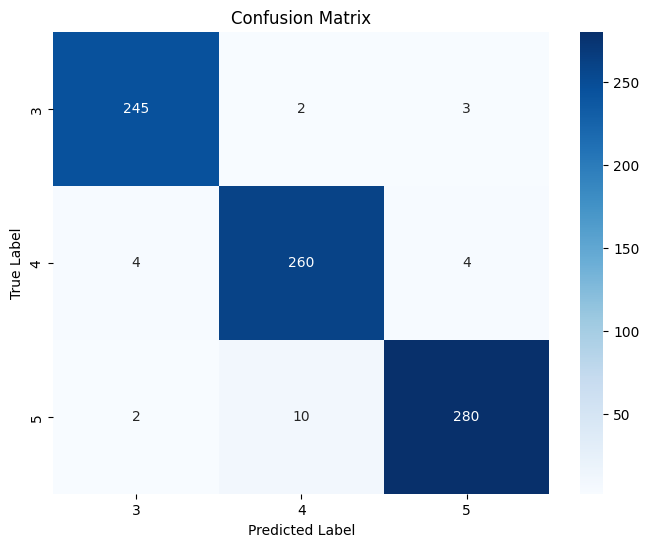

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Función para plotear la matriz de confusión
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Obtener y mostrar las matrices de confusión
cmMNB = confusion_matrix(y_test, predictMNB)
print("MNB Confusion Matrix")
plot_confusion_matrix(cmMNB, classes=y.unique())

cmCNB = confusion_matrix(y_test, predictCNB)
print("CNB Confusion Matrix")
plot_confusion_matrix(cmCNB, classes=y.unique())

cmSVC = confusion_matrix(y_test, predictSVC)
print("SVC Confusion Matrix")
plot_confusion_matrix(cmSVC, classes=y.unique())

cmRF = confusion_matrix(y_test, predictRF)
print("RF Confusion Matrix")
plot_confusion_matrix(cmRF, classes=y.unique())

cmGB = confusion_matrix(y_test, predictGB)
print("GB Confusion Matrix")
plot_confusion_matrix(cmGB, classes=y.unique())

cmLR = confusion_matrix(y_test, predictLR)
print("LR Confusion Matrix")
plot_confusion_matrix(cmLR, classes=y.unique())

Las métricas de calidad utilizadas en los modelos, como el **AUC-ROC** y la **matriz de confusión**, juegan un papel clave en el análisis y contribuyen directamente al cumplimiento de los objetivos del negocio. El **AUC-ROC** nos permite medir cómo de bien los modelos pueden diferenciar entre las distintas categorías de los Objetivos de Desarrollo Sostenible (ODS), asegurando que las predicciones sean precisas y consistentes. Esto es crucial para identificar con claridad los comentarios de los ciudadanos y asignarlos a los ODS correctos (3, 4 y 5), lo cual ayuda en la toma de decisiones basada en datos confiables.

La **matriz de confusión** nos proporciona un análisis más granular, indicando cuántas veces cada modelo acierta o falla al clasificar las opiniones en cada ODS. Al observar la diagonal de la matriz, que indica las predicciones correctas, podemos identificar qué tan bien está desempeñándose el modelo en términos de precisión. Las métricas de calidad de los modelos son esenciales para asegurar que las clasificaciones automáticas sean lo suficientemente precisas para reducir la intervención manual de los expertos, lo que a su vez optimiza recursos y mejora la eficiencia operativa del proyecto.

En conjunto, estos análisis métricos aseguran que la solución sea precisa, eficiente y capaz de escalar para cubrir un mayor volumen de comentarios, lo que apoya la misión del negocio de mejorar el análisis de participación ciudadana y su vinculación con los ODS.

In [53]:
from sklearn.metrics import roc_auc_score, roc_curve

# Calcula el AUC-ROC para cada modelo
aucMNB = roc_auc_score(y_test, pipeMNB.predict_proba(X_test), multi_class='ovr')
aucCNB = roc_auc_score(y_test, pipeCNB.predict_proba(X_test), multi_class='ovr')
#aucSVC = roc_auc_score(y_test, pipeSVC.decision_function(X_test), multi_class='ovr')
aucRF = roc_auc_score(y_test, pipeRF.predict_proba(X_test), multi_class='ovr')
aucGB = roc_auc_score(y_test, pipeGB.predict_proba(X_test), multi_class='ovr')
aucLR = roc_auc_score(y_test, pipeLR.predict_proba(X_test), multi_class='ovr')

print("AUC MNB:", aucMNB)
print("AUC CNB:", aucCNB)
#print("AUC SVC:", aucSVC)
print("AUC RF:", aucRF)
print("AUC GB:", aucGB)
print("AUC LR:", aucLR)

# Obtener la suma de los valores correctos (diagonal) para cada matriz de confusión
correctMNB = cmMNB.trace()
correctCNB = cmCNB.trace()
correctSVC = cmSVC.trace()
correctRF = cmRF.trace()
correctGB = cmGB.trace()
correctLR = cmLR.trace()

print("MNB Correct Predictions:", correctMNB)
print("CNB Correct Predictions:", correctCNB)
print("SVC Correct Predictions:", correctSVC)
print("RF Correct Predictions:", correctRF)
print("GB Correct Predictions:", correctGB)
print("LR Correct Predictions:", correctLR)



AUC MNB: 0.9959576227345712
AUC CNB: 0.9969977466784034
AUC RF: 0.9955028070718684
AUC GB: 0.9961590767534872
AUC LR: 0.997186188424045
MNB Correct Predictions: 738
CNB Correct Predictions: 777
SVC Correct Predictions: 792
RF Correct Predictions: 772
GB Correct Predictions: 779
LR Correct Predictions: 785


#### Algoritmo elegido: SVC por mayor número de predicciones correctas

#### Análisis de palabras más significativas

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import numpy as np
import pandas as pd

# Obtener el vectorizador TF-IDF del pipeline
vectorizer = pipeSVC.named_steps['tfi']
feature_names = vectorizer.get_feature_names_out()

# Obtener el modelo LinearSVC
svc_model = pipeSVC.named_steps['clf']

# Extraer coeficientes de las clases
coef = svc_model.coef_  # No es necesario usar toarray()

# Crear un DataFrame para las palabras y sus coeficientes
coef_df = pd.DataFrame(coef, columns=feature_names)

# Número de palabras más importantes a mostrar
top_n = 10  

# Analizar las palabras más importantes para cada clase
for class_idx in range(coef.shape[0]):
    # Obtener índices de las palabras más importantes
    top_words_idx = np.argsort(coef[class_idx])[::-1][:top_n]
    top_words = [feature_names[idx] for idx in top_words_idx]
    top_scores = coef[class_idx][top_words_idx]
    print(f"Class {class_idx}:")
    for word, score in zip(top_words, top_scores):
        print(f"  {word}: {score:.4f}")



Class 0:
  l u d: 1.7816
  s a l u: 1.7807
  a l u d: 1.7773
  l u d  : 1.6432
    s a: 1.4200
  u d  : 1.4086
  a c i e: 1.1844
  n c i ó: 1.1371
    s a l: 1.1137
  s a l: 1.1125
Class 1:
  d u c a: 1.4673
  u c a: 1.4636
    e d u: 1.4505
    e d: 1.4470
  u c a c: 1.2565
  u d i a: 1.1736
    e s c: 1.1607
  e d u: 1.1455
  e d u c: 1.1311
  d i a n: 1.1015
Class 2:
  m u j: 2.2784
  m u j e: 2.2784
  u j e r: 2.2764
  u j e: 2.2735
  u j: 2.2637
  j e r  : 2.2449
    m u j: 2.2154
  j e r: 2.0851
  é n e r: 1.7886
    g é: 1.7886


En el análisis de las palabras identificadas para cada clase en el modelo SVC, se observa una variedad de términos que pueden ser vinculados con distintos Objetivos de Desarrollo Sostenible (ODS). En la Clase 0, palabras como "salu" (salud), "alud" y "ac" sugieren una fuerte orientación hacia temas de salud y bienestar, lo que podría alinearse con el ODS 3 (Salud y Bienestar). La prevalencia de términos relacionados con la salud en esta clase sugiere que las opiniones en esta categoría podrían estar enfocadas en la mejora de servicios de salud, acceso a cuidados médicos, o bienestar general. Para abordar estas preocupaciones, la organización podría desarrollar estrategias para fortalecer sus programas de salud, asegurando un mejor acceso y calidad en los servicios de atención médica.

En la Clase 1, se identifican palabras como "educ", "educa", y "d u c a" que apuntan claramente a temas de educación, correlacionados con el ODS 4 (Educación de Calidad). Esto indica que las opiniones en esta clase probablemente se centran en la calidad de la educación, la capacitación y el desarrollo académico. Para mejorar en esta área, la organización debería considerar implementar o expandir programas educativos, mejorar los recursos de formación y capacitación, y evaluar la calidad de la educación que ofrecen.

La Clase 2 destaca términos como "mujer", "mujer", y "energ", que sugieren un enfoque en cuestiones de género y energía, posiblemente vinculadas con el ODS 5 (Igualdad de Género) y el ODS 7 (Energía Asequible y No Contaminante). La presencia de estos términos indica que las opiniones pueden estar orientadas hacia la igualdad de género y el acceso a recursos energéticos sostenibles. La organización debería considerar desarrollar estrategias para promover la igualdad de género dentro de sus políticas y operaciones, así como adoptar prácticas sostenibles y eficientes en el uso de la energía.

Este análisis es útil para la organización ya que proporciona una visión clara de los temas recurrentes en las opiniones, permitiendo una alineación estratégica con los ODS relevantes. Implementar estrategias basadas en estos resultados no solo puede mejorar la efectividad de los programas existentes, sino también asegurar que las iniciativas de la organización estén directamente relacionadas con las necesidades y preocupaciones identificadas en las opiniones, fortaleciendo así su impacto y relevancia en la comunidad.

#### Predicción con datos finales

In [55]:
# Cargar los datos finales
df = pd.read_excel('TestODScat_345.xlsx')

# Definir las características (texto) para hacer predicciones
X = df['Textos_espanol']

# Hacer predicciones utilizando el modelo entrenado
df['svg'] = pipeSVC.predict(X)

# Guardar el DataFrame con las predicciones en un nuevo archivo Excel
df.to_excel('datafinal_with_predictions.xlsx', index=False)

print("Predicciones guardadas en 'datafinal_with_predictions.xlsx'.")


Predicciones guardadas en 'datafinal_with_predictions.xlsx'.
